# "Quantum" Keyword Example

## General Project Description:
This project makes use of the Arxive API. Arxive is an online database of research papers.

The idea of this project is to use a keyword to find related articles. The pipeline is as follows:
1. User inputs an inital keyword.

2. The program makes a call to the Arxive API and takes some articles, storing their titles, authors, date, and link in a pandas dataframe.

3. We use Google Gemini to determine related keywords, noting which keywords are associated with which article. Google gemini also creates a similarity score between articles.

4. We use a cosine similiarty score to combine keywords. For example, we would want to combine "computer" and "computers" since they are essentially the same word. The actual score threshold can be set by the user.

5. The program iterates on each keyword to find more articles. The Arxive API is called again (with the new keyword) and articles are
taken. Steps 3 to 4 are repeated until either every keyword has been searched through or a user decided number has been reached (that is, the user can say only search through the first three keywords, for example).

6. Using Gemini's similairty score, create pairs of papers and assign a similarity score between them. This is stored in a dataframe with the columns "paper 1", "paper 2", and "score".

7. Using this dataframe, we create and display a graph using the "score" column as edge weights between papers.

The main function, `find_similar_papers`, returns a list of all the keywords, a dataframe of all the papers (with their authors, links, and dates), and the dataframe form of the graph. This allows the user to pick whatever mode is most convient for them to search through/look at the papers and their relatedness.

Most of the functions used in this program are in the `Embed.py` file under the `Embed` class.

## This Notebook:
The following script is an example usage of this program. It uses the keyword "quantum". It goes through exaclty the process described above.

In [2]:
import os
import pandas as pd
from queue import Queue
from google import genai
from dotenv import load_dotenv

import Query as aq
import Embed as eb

In [3]:
load_dotenv()
api_key = os.getenv('api_key')

def keyword_dict_merge(dict1, dict2):
    """ This just mereges two keyword dictionaries.
    It basically removes duplicate keyword values and
    correctly appends papers to the value list.
    """
    merged = {}
    all_keys = set(dict1) | set(dict2)

    for key in all_keys:
        combined_scores = {}
        for d in (dict1, dict2):
            if key in d:
                for idx, score in d[key]:
                    if idx in combined_scores:
                        combined_scores[idx] = max(combined_scores[idx], score)
                    else:
                        combined_scores[idx] = score
        merged[key] = [(idx, score) for idx, score in combined_scores.items()]
    return merged

def find_similar_papers(keyword, api_key, paper_n=3, rounds=2, similiarity_threshold=0.75, q_size=5):
    """ Finds and links similar research papers from Arxiv based on a starting keyword.
    """
    client = genai.Client(api_key=api_key)
    emb = eb.Embed(client, similiarity_threshold)
    df = pd.DataFrame(columns=['title', 'summary', 'published', 'authors', 'link'])

    # Get initial query
    query = aq.ArxivQuery(keyword, paper_n)
    query.df = query.df.reset_index(drop=True)
    df = pd.concat([df, query.df], ignore_index=True)

    keywords = emb.extract_keywords(query.df)
    all_keywords = {}

    for key, values in keywords.items():
        all_keywords[key] = [(int(idx), score) for idx, score in values]

    # Iterate through the keywords to add papers to our dataframe
    q = Queue()
    seen_terms = set()
    for i in range(rounds):
        for term in keywords:
            if term not in seen_terms:
                q.put(term)
                seen_terms.add(term)

        j = 0
        while j < q_size:
            if q.empty():
                break

            new_term = q.get()
            query = aq.ArxivQuery(new_term, paper_n)
            qdf = query.df.reset_index(drop=True)
            start_idx = len(df)
            df = pd.concat([df, qdf], ignore_index=True)
            keywords = emb.extract_keywords(qdf)
            shifted_keywords = {}
            for key, values in keywords.items():
                shifted_keywords[key] = [(start_idx + int(idx), score) for idx, score in values]
            all_keywords = keyword_dict_merge(all_keywords, shifted_keywords)
            j += 1

    # Link papers and create graph
    linked_papers = emb.link_papers(df, all_keywords)
    G = emb.build_graph_from_links(linked_papers)
    emb.display_graph_with_weights(G)
    return G, all_keywords, df

  Depending on the field of study, the correct threshold may differ. For example, there are a lot of similar terms (terms that start with "quantum") in quantum mechanics and quantum computing, so I lowered the threshold. It can also take a little while for this to happen depending on how many rounds you do becuase it can increase the number of keywords exponentially.

quantum grammars
(0, 0.9) (3, 0.9)
(0, 0.9) (6, 0.9)
(3, 0.9) (6, 0.9)
quantum assembly language
(0, 0.8) (1, 0.8)
quantum state
(12, 0.9) (20, 0.8)
quantum Turing Machine
(9, 0.9) (10, 0.9)
(9, 0.9) (11, 0.9)
(10, 0.9) (11, 0.9)
quantum states
(1, 0.9) (17, 0.9)
(1, 0.9) (23, 0.7)
(1, 0.9) (32, 0.9)
(17, 0.9) (23, 0.7)
(17, 0.9) (32, 0.9)
(23, 0.7) (32, 0.9)
spin squeezing
(17, 0.8) (32, 0.7)
class complexity
(24, 0.9) (25, 0.9)
quantum assembly
(3, 0.7) (6, 0.7)
(3, 0.7) (7, 0.7)
(3, 0.7) (8, 0.9)
(6, 0.7) (7, 0.7)
(6, 0.7) (8, 0.9)
(7, 0.7) (8, 0.9)
multipartite entanglement
(15, 0.95) (27, 0.8)
(15, 0.95) (28, 0.9)
(15, 0.95) (29, 0.9)
(15, 0.95) (30, 0.95)
(27, 0.8) (28, 0.9)
(27, 0.8) (29, 0.9)
(27, 0.8) (30, 0.95)
(28, 0.9) (29, 0.9)
(28, 0.9) (30, 0.95)
(29, 0.9) (30, 0.95)
symmetric states
(1, 0.7) (12, 0.7)
ground state
(16, 0.8) (31, 0.8)
quantum complexity
(2, 0.95) (18, 0.9)
(2, 0.95) (20, 0.9)
(18, 0.9) (20, 0.9)
symmetric state
(15, 0.9) (16, 0.9)
(15, 0.9) (30, 0.85)
(1

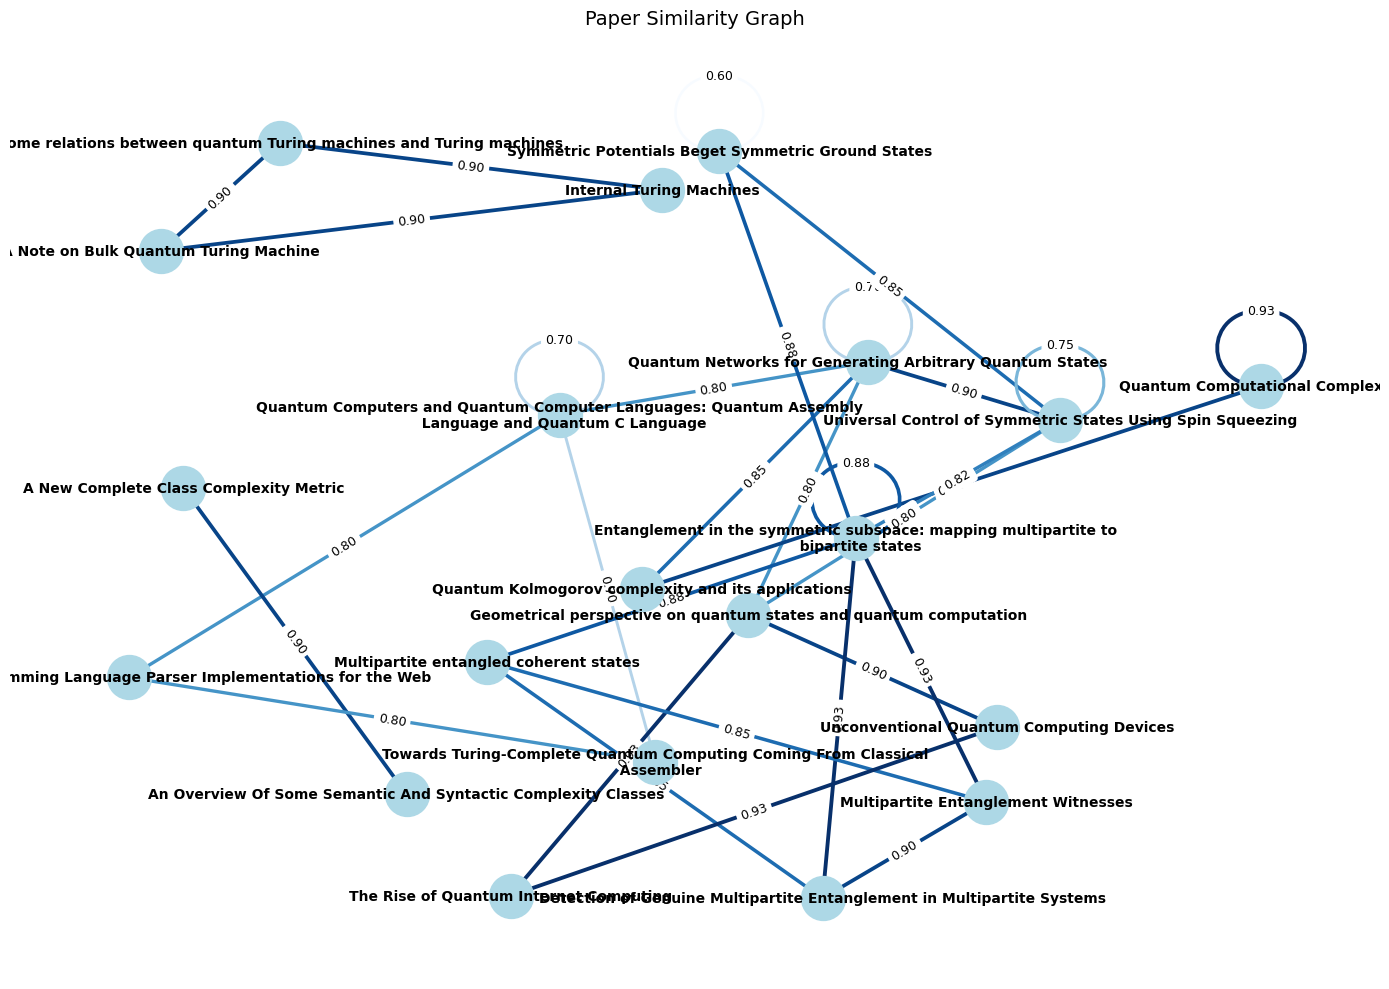

In [4]:
G, all_keywords, df = find_similar_papers("quantum", api_key, paper_n = 3, similiarity_threshold = 0.75)

Above is the graph generated by our function. We can also opt to see the complete dataframe of papers selected instead.

In [5]:
df

,title,summary,published,authors,link
0,Quantum Computers and Quantum Computer Languag...,We show a representation of Quantum Computers ...,2002,[Stephen Blaha],http://arxiv.org/abs/quant-ph/0201082v1
1,Quantum Networks for Generating Arbitrary Quan...,Quantum protocols often require the generation...,2004,"[Phillip Kaye, Michele Mosca]",http://arxiv.org/abs/quant-ph/0407102v1
2,Quantum Computational Complexity,This article surveys quantum computational com...,2008,[John Watrous],http://arxiv.org/abs/0804.3401v1
3,Quantum Computers and Quantum Computer Languag...,We show a representation of Quantum Computers ...,2002,[Stephen Blaha],http://arxiv.org/abs/quant-ph/0201082v1
4,"Graph Grammars, Insertion Lie Algebras, and Qu...",Graph grammars extend the theory of formal lan...,2015,"[Matilde Marcolli, Alexander Port]",http://arxiv.org/abs/1502.07796v1
5,Complexity of Grammar Induction for Quantum Types,Most categorical models of meaning use a funct...,2014,[Antonin Delpeuch],http://arxiv.org/abs/1404.3925v2
6,Quantum Computers and Quantum Computer Languag...,We show a representation of Quantum Computers ...,2002,[Stephen Blaha],http://arxiv.org/abs/quant-ph/0201082v1
7,Towards Turing-Complete Quantum Computing Comi...,Instead of producing quantum languages that ar...,2022,"[Thomas Gabor, Marian Lingsch Rosenfeld, Claud...",http://arxiv.org/abs/2206.14037v1
8,Three Quantum Programming Language Parser Impl...,IBM has developed a quantum assembly (QASM) la...,2023,[Marcus Edwards],http://arxiv.org/abs/2310.10802v1
9,A Note on Bulk Quantum Turing Machine,"Recently, among experiments for realization of...",2004,[Tetsushi Matsui],http://arxiv.org/abs/cs/0411037v2
